In [ ]:
import torch # 1.9
import torchvision
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import cv2
import os

import warnings
warnings.filterwarnings("ignore")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu' # for debug建議使用cpu作為torch的運行背景
device

<!-- # ## Chapter1 : UNet網路構建

# ### ConvBlock
# - 加入Instance Norm.
# - <img src="https://miro.medium.com/max/983/1*p84Hsn4-e60_nZPllkxGZQ.png" 512="50%">
# 
# > 上圖為一整個batch的feature-map。輸入6張圖片，輸入6chs, 輸出也是6chs(C方向看進去是channel, N方向看進去是圖片) -->


## Chapter1 : UNet網路構建
ref: https://amaarora.github.io/2020/09/13/unet.html

### ConvBlock
- 加入Instance Norm.
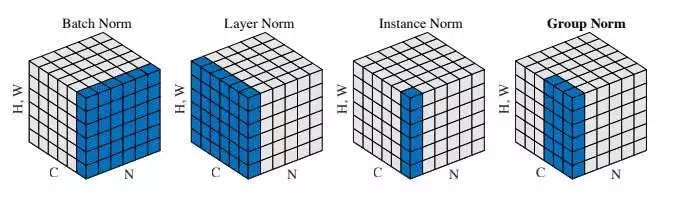
> 上圖皆為一整個batch的feature-map。輸入6張圖片，輸入6chs, 輸出也是6chs(C方向看進去是channel, N方向看進去是圖片)

In [ ]:
# # 原始版本
# class convBlock(nn.Module):
#     def __init__(self, in_ch, out_ch):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
#         self.relu  = nn.ReLU()
#         self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
    
#     def forward(self, x):
#         return self.relu(self.conv2(self.relu(self.conv1(x))))


# In[5]:


## 加入instance normalization
class convBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, padding = 0):
        super().__init__()
        kernel_size = kernel_size
        pad_same_value = lambda kernel_size:(kernel_size-1)//2
        
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size, padding=padding, bias=False)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size, padding=padding, bias=False)
        self.INorm = torch.nn.InstanceNorm2d(out_ch, affine=True)
        
    def forward(self, x):
        x = self.INorm(self.conv1(x))
        x = self.relu(x)
        x = self.INorm(self.conv2(x))
        x = self.relu(x)
        return x
    
if __name__ == '__main__':
    block = convBlock(1, 64, 3, padding=1)
    WIDTH, HEIGHT = (512, 512)
    x = torch.randn(1, 1, WIDTH, HEIGHT)
    print(block(x).shape)

In [ ]:
# ## Encoder(DownStream)
# 將影像進行編碼(下採樣)，過程中解析度會被縮小、讓Unet能學到不同層次的特徵(maxpooling、convolution)
class Down(nn.Module):
    def __init__(self, in_ch, out_ch, padding=True):
        super().__init__()
        pad = 1 if (padding==True or padding=='same') else 0

        self.conv = convBlock(in_ch, out_ch, 3, pad)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        return x

#  將影像做上採樣，同時concat來自編碼路徑的feature map
class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True, padding=True):
        super().__init__()
        if bilinear:
            # normal convolutions to reduce the number of channels
            self.up = nn.Sequential(nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True),
                                    nn.Conv2d(in_ch, (in_ch // 2), 3, padding=1, bias=True))
        else:
            self.up = nn.ConvTranspose2d(in_ch, (in_ch // 2), kernel_size = 2, stride = 2)

        pad = 1 if (padding==True or padding=='same') else 0
        self.conv = convBlock(in_ch, out_ch, 3, padding=pad)
    
    def forward(self, x, enc_ftrs):
        x = self.up(x)
        enc_ftrs = self.crop(enc_ftrs, x)
        x = torch.cat([x, enc_ftrs], dim=1)
        x = self.conv(x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

# Unet, 2015
### 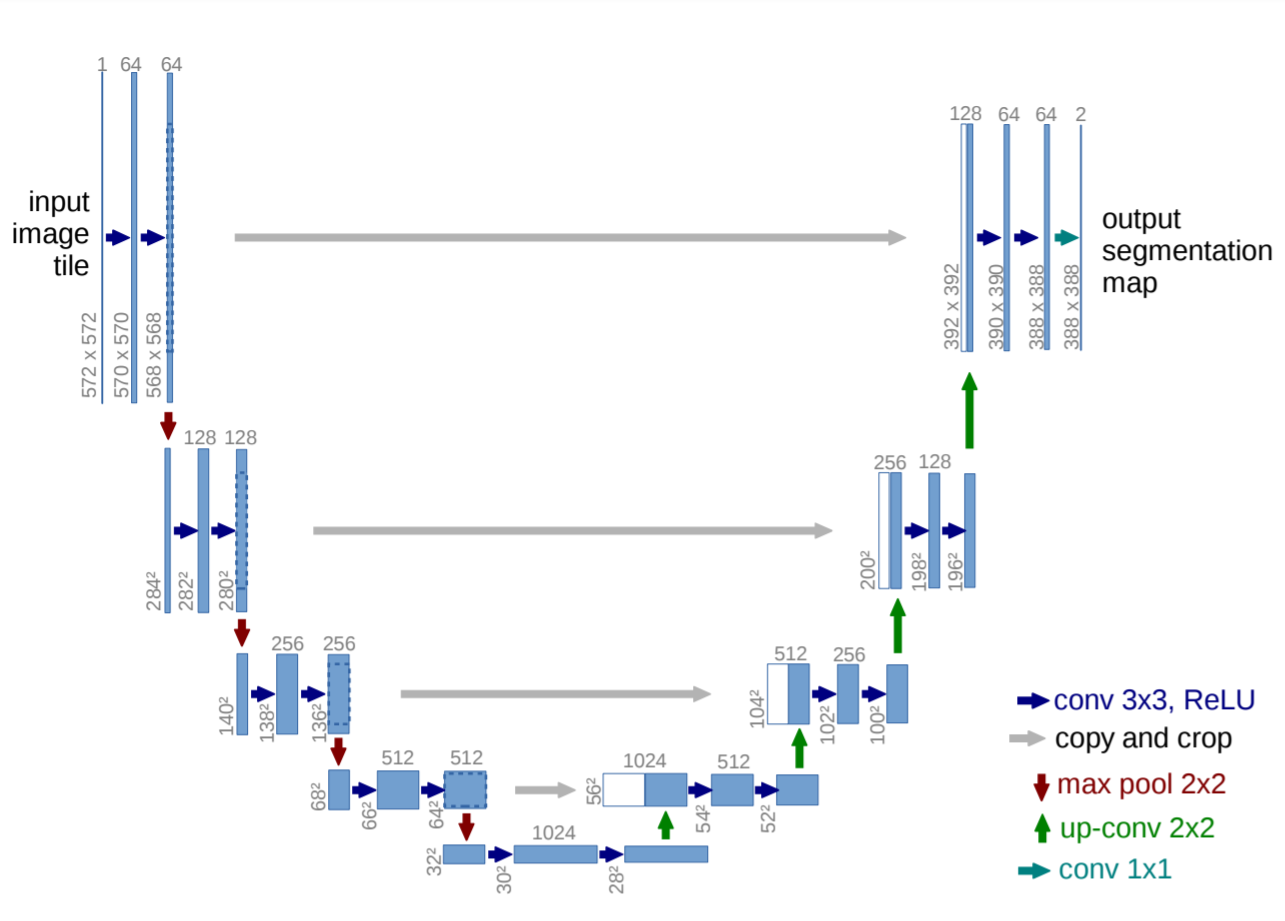

In [ ]:
## Unet構建
# 結合encoder和decoder組成Unet。
# 在輸出層如果用softmax做多元分類問題預測的話，類別數量要+1(num_classes+background)
class UNet(nn.Module):
    def __init__(self, out_sz, in_ch, out_ch, bilinear=True, activation=None):
        super().__init__()     
        if isinstance(out_sz,(int)): self.out_sz = (out_sz, out_sz)
        if isinstance(out_sz,(tuple,list)): self.out_sz = tuple(out_sz)
        
        chs = (64, 128, 256, 512, 1024)
        
        self.head = nn.Conv2d(chs[0], out_ch, 1)
        self.activation = activation
        self.out_sz = out_sz
        
        '''
        Unet with nn.ModuleList
        '''
        self.input = convBlock(in_ch, chs[0], 3, padding=1)
        self.down_list = nn.ModuleList([Down(chs[i], chs[i+1], padding='same')for i in range(len(chs)-1)]) 
        chs = chs[::-1]
        self.up_list = nn.ModuleList([Up(chs[i], chs[i+1], padding='same')for i in range(len(chs)-1)]) 
        
        '''
        Unet with simple code
        ---
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512, bilinear)
        self.up2 = Up(512, 256, bilinear)
        self.up3 = Up(256, 128, bilinear)
        self.up4 = Up(128, 64, bilinear)
        '''
        
    def forward(self, x):
        down_layer_0 = self.input(x)
        
        'Unet with nn.ModuleList'
        enc_ftrs = [down_layer_0]
        for idx in range(len(self.down_list)):
            outputs = self.down_list[idx](enc_ftrs[idx])
            enc_ftrs.append(outputs)
        enc_ftrs = enc_ftrs[::-1]
        
        tmp_ftr = enc_ftrs[0]
        for idx in range(len(self.up_list)):
            tmp_ftr = self.up_list[idx](tmp_ftr, enc_ftrs[idx+1])
        
        '''
        Unet with simple code
        ---
        down_layer_1 = self.down1(down_layer_0)
        down_layer_2 = self.down2(down_layer_1)
        down_layer_3 = self.down3(down_layer_2)
        down_layer_4 = self.down4(down_layer_3)
        up_layer_1 = self.up1(down_layer_4, down_layer_3)
        up_layer_2 = self.up2(up_layer_1, down_layer_2)
        up_layer_3 = self.up3(up_layer_2, down_layer_1)
        tmp_ftr = self.up4(up_layer_3, down_layer_0)
        '''


        logits = self.head(tmp_ftr)
        
        # interpolate 
        _, _, H, W = logits.shape
        if (H,W)==self.out_sz: pass
        else:
            logits = F.interpolate(logits, self.out_sz)
        
        # add activation (not necessary)
        if self.activation:
            logits = self.activation(logits)
        
        return logits

# ResUnet, 2017
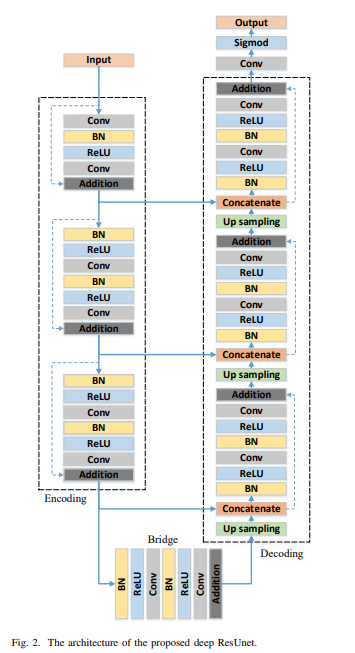

In [ ]:
'''
跟普通的ConvBlock比起來，多做了一個skip & add的動作
---
使用心得: Residual有讓輪廓資訊保留更多的傾向，這在原始論文的道路檢測上是好的，但對瑕疵檢測的議題不見得好，需要更多的訓練來de-noise。
'''
class ResidualConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=2, padding='same'):
        super().__init__()
        pad_size = lambda kernel_size:(kernel_size-1)//2
        kernel_size = 3
        pad = pad_size(kernel_size) if padding=='same' else padding   
        
        self.conv_block = nn.Sequential(
          nn.BatchNorm2d(in_ch),
#           nn.InstanceNorm2d(in_ch),
          nn.ReLU(),
          nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=pad),
          nn.BatchNorm2d(out_ch),
#           nn.InstanceNorm2d(out_ch),
          nn.ReLU(),
          nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=pad),
          )
        self.conv_skip = nn.Sequential(
          nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=pad),
            nn.BatchNorm2d(out_ch),
        )

    def forward(self, x):
        return self.conv_block(x) + self.conv_skip(x)
    
class ResUnet(nn.Module):
    def __init__(self, out_sz, in_ch, out_ch, bilinear=True, activation=None):
#     def __init__(self, num_classes=1, channel=3, filters=[64, 128, 256, 512], activation=nn.Sigmoid()):
        super(ResUnet, self).__init__()
        if isinstance(out_sz,(int)): self.out_sz = (out_sz, out_sz)
        if isinstance(out_sz,(tuple,list)): self.out_sz = tuple(out_sz)
        
        chs = (64, 128, 256, 512, 1024)
        
        self.head = nn.Conv2d(chs[0], out_ch, 1)
        self.activation = activation
        self.out_sz = out_sz
        
        '''
        Unet with nn.ModuleList
        '''
        self.input_layer = nn.Sequential(
            nn.Conv2d(in_ch, chs[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(chs[0]),
            nn.ReLU(),
            nn.Conv2d(chs[0], chs[0], kernel_size=3, padding=1),
        )
        self.input_skip = nn.Sequential(
            nn.Conv2d(in_ch, chs[0], kernel_size=3, padding=1)
        )
        self.down_list = nn.ModuleList([ResidualConvBlock(chs[i], chs[i+1], 2, padding='same') for i in range(len(chs)-1)]) 
        chs = chs[::-1]
        self.up_list = nn.ModuleList([Up(chs[i], chs[i+1], bilinear=True, padding='same') for i in range(len(chs)-1)]) 


    def forward(self, x):
        x = self.input_layer(x) + self.input_skip(x)
        
        enc_ftrs = [x]
        for idx in range(len(self.down_list)):
            outputs = self.down_list[idx](enc_ftrs[idx])
            enc_ftrs.append(outputs)
        enc_ftrs = enc_ftrs[::-1]
        
        tmp_ftr = enc_ftrs[0] 
        for idx in range(len(self.up_list)):
            tmp_ftr = self.up_list[idx](tmp_ftr, enc_ftrs[idx+1])
        
        logits = self.head(tmp_ftr)
        
        # interpolate 
        _, _, H, W = logits.shape
        if (H,W)==self.out_sz: pass
        else:
            logits = F.interpolate(logits, self.out_sz)
        
        # add activation (not necessary)
        if self.activation:
            logits = self.activation(logits)
        
        return logits
    

# Attention Unet, 2018
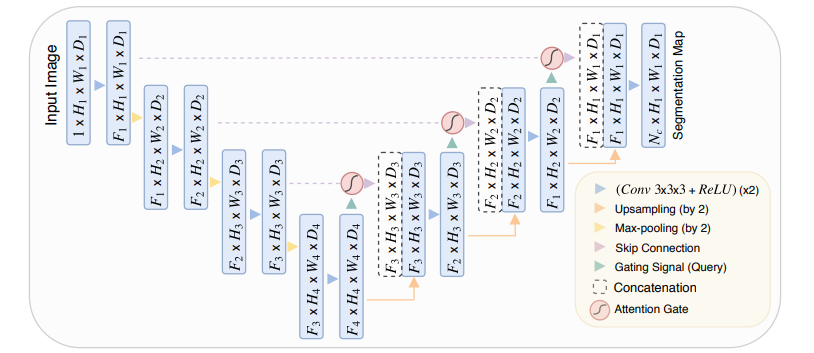

In [ ]:
'''
attention block並不真的使用attention layer，
而是用一個輕量的模組對邊碼路徑產出、即將concat到解碼路徑上的特徵向量做重要性評估，
概念上也許比較像LSTM的gate。
相近論文: SE-net>>>SE-Unet (Squeeze-and-Excitation Block:)
---
ref: 
Semantic Segmentation with Squeeze-and-Excitation Block: Application to Infarct Segmentation in DWI, Medical Imaging Meets NIPS workshop, NIPS 2017
'''

# 一個輕量的、channel-wise的特徵向量重要性判斷模組
class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi
    
# 加入Attention_block的上採樣，在cat之前先用Attention_block作加權
class Att_Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True, padding=True):
        super().__init__()
        if bilinear:
            # normal convolutions to reduce the number of channels
            self.up = nn.Sequential(nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True),
                                    nn.Conv2d(in_ch, (in_ch // 2), 3, padding=1, bias=True))
        else:
            self.up = nn.ConvTranspose2d(in_ch, (in_ch // 2), kernel_size = 2, stride = 2)

        pad = 1 if (padding==True or padding=='same') else 0
        self.att = Attention_block(F_g=out_ch, F_l=out_ch, F_int=out_ch//2)
        self.conv = convBlock(in_ch, out_ch, 3, padding=pad)
        
    def forward(self, x, enc_ftrs):
        x = self.up(x)
        enc_ftrs = self.crop(enc_ftrs, x)
        enc_ftrs = self.att(x, enc_ftrs)
        x = torch.cat([x, enc_ftrs], dim=1)
        x = self.conv(x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs
    
class AttUnet(nn.Module):
    def __init__(self, out_sz, in_ch, out_ch, bilinear=True, activation=None):
        super().__init__()     
        if isinstance(out_sz,(int)): self.out_sz = (out_sz, out_sz)
        if isinstance(out_sz,(tuple,list)): self.out_sz = tuple(out_sz)
        
        chs = (64, 128, 256, 512, 1024)
        
        self.head = nn.Conv2d(chs[0], out_ch, 1)
        self.activation = activation
        self.out_sz = out_sz
        
        '''
        Unet with nn.ModuleList
        '''
        self.input = convBlock(in_ch, chs[0], 3, padding=1)
        self.down_list = nn.ModuleList([Down(chs[i], chs[i+1], padding='same')for i in range(len(chs)-1)]) 
        chs = chs[::-1]
        self.up_list = nn.ModuleList([Att_Up(chs[i], chs[i+1], padding='same')for i in range(len(chs)-1)]) 
        
        
    def forward(self, x):
        down_layer_0 = self.input(x)
        
        'Unet with nn.ModuleList'
        enc_ftrs = [down_layer_0]
        for idx in range(len(self.down_list)):
            outputs = self.down_list[idx](enc_ftrs[idx])
            enc_ftrs.append(outputs)
        enc_ftrs = enc_ftrs[::-1]
        
        tmp_ftr = enc_ftrs[0]
        for idx in range(len(self.up_list)):
            tmp_ftr = self.up_list[idx](tmp_ftr, enc_ftrs[idx+1])

        logits = self.head(tmp_ftr)
        
        # interpolate 
        _, _, H, W = logits.shape
        if (H,W)==self.out_sz: pass
        else:
            logits = F.interpolate(logits, self.out_sz)
        
        # add activation (not necessary)
        if self.activation:
            logits = self.activation(logits)
        
        return logits

In [1]:
import os
try:
    if get_ipython().__class__.__name__=='ZMQInteractiveShell':
        os.system('jupyter nbconvert unet.ipynb --to python')
except NameError:
    pass

[NbConvertApp] Converting notebook unet.ipynb to python
[NbConvertApp] Writing 13746 bytes to unet.py
